In [1]:
%pip install --quiet --upgrade pip jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab pyarrow numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
from matplotlib import pyplot as plt, dates, ticker
import numpy as np
%load_ext sql
%matplotlib widget
conn = duckdb.connect()
%sql conn --alias duckdb
pd.options.mode.copy_on_write = True

/home/flapkap/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Deploy AI and data apps for free on Ploomber Cloud! Sign up here: https://www.platform.ploomber.io/register


In [3]:
%config SqlMagic.autopandas = True
#%config SqlMagic.displaycon = False

In [4]:
%%sql
INSTALL sqlite;
LOAD sqlite;

Running query in 'duckdb'

,Success


In [5]:
%%sql
ATTACH '397568.db' AS expdb (TYPE SQLITE) ;
USE expdb.main;

Running query in 'duckdb'

,Success


In [6]:
# set some matplotlib defaults
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator, MicrosecondLocator
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
plt.rcParams['svg.fonttype'] = 'none'
# Set the global locator and formatter
plt.rcParams['date.autoformatter.microsecond'] = '%S.%f'  # Set the global format for microsecond level
plt.rcParams['date.autoformatter.second'] = '%H:%M:%S'  # Set the global format for second level
plt.rcParams['date.autoformatter.minute'] = '%H:%M'  # Set the global format for minute level
plt.rcParams['date.autoformatter.hour'] = '%Y-%m-%d %H:%M'  # Set the global format for hour level
plt.rcParams['date.autoformatter.day'] = '%Y-%m-%d %H:%M'  # Set the global format for day level
plt.rcParams['date.autoformatter.month'] = '%Y-%m-%d %H:%M'  # Set the global format for month level
plt.rcParams['date.autoformatter.year'] = '%Y-%m-%d %H:%M'  # Set the global format for year level


In [7]:
%sql SHOW;

Running query in 'duckdb'

,database,schema,name,column_names,column_types,temporary
0,expdb,main,Join_Message,"[join_message_id, app_received_at]","[BIGINT, TIMESTAMP]",False
1,expdb,main,Message,"[message_id, related_node, network_received_at]","[BIGINT, VARCHAR, TIMESTAMP]",False
2,expdb,main,Node,"[node_deveui, node_appeui, node_appkey, board_...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, ...",False
3,expdb,main,Power_Consumption,"[power_consumption_id, node_id, timestamp, cur...","[BIGINT, VARCHAR, TIMESTAMP, DOUBLE, DOUBLE, D...",False
4,expdb,main,Radio,"[radio_id, timestamp, node_id, channel, rssi]","[BIGINT, TIMESTAMP, VARCHAR, BIGINT, BIGINT]",False
5,expdb,main,Site,[name],[VARCHAR],False
6,expdb,main,Trace,"[trace_id, node_id, timestamp, message]","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR]",False
7,expdb,main,Uplink_Message,"[uplink_message_id, through_gateway, gateway_r...","[BIGINT, VARCHAR, TIMESTAMP, TIMESTAMP, BIGINT...",False
8,expdb,main,sqlite_sequence,"[name, seq]","[BLOB, BLOB]",False


In [8]:
hej = %sql select message from expdb.Trace WHERE message LIKE 'TIMINGS>%'

Running query in 'duckdb'

In [9]:
hej["message"][0]

'TIMINGS> Loop: 0, Sync: 806 ms, Load: 21 ms, sensor init: 26 ms, env init: 0 ms, net init: 8628 ms, Collect: -1 ms, Exec: -1 ms, Send: 8072 ms, save config: 697 ms, Sleep: 6 s\n'

In [10]:
%sql nodes =<< select distinct * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA75,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA78,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1
3,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1
5,70B3D57ED005EA70,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
6,70B3D57ED005EA72,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1
9,70B3D57ED005EA69,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0


In [11]:
%%sql
DESCRIBE expdb.Trace

Running query in 'duckdb'

,column_name,column_type,null,key,default,extra


In [12]:
%%sql
select * from expdb.Power_Consumption WHERE node_id= '70B3D57ED005EA60' limit 5

Running query in 'duckdb'

,power_consumption_id,node_id,timestamp,current,voltage,power
0,9603263,70B3D57ED005EA60,2024-05-06 20:08:31.602826,0.058263,4.96375,0.289363
1,9603264,70B3D57ED005EA60,2024-05-06 20:08:31.603955,0.058044,4.96000,0.288753
2,9603265,70B3D57ED005EA60,2024-05-06 20:08:31.605053,0.058117,4.96375,0.288753
3,9603266,70B3D57ED005EA60,2024-05-06 20:08:31.606182,0.058166,4.96500,0.288753
4,9603267,70B3D57ED005EA60,2024-05-06 20:08:31.607311,0.058019,4.96375,0.288143


In [13]:

timestamps= %sql select timestamp from expdb.Power_Consumption 
timestamps

Running query in 'duckdb'

,timestamp
0,2024-05-06 20:08:31.249936
1,2024-05-06 20:08:31.251065
2,2024-05-06 20:08:31.252194
3,2024-05-06 20:08:31.253293
4,2024-05-06 20:08:31.254422
...,...
20344295,2024-05-06 20:28:37.312516
20344296,2024-05-06 20:28:37.313615
20344297,2024-05-06 20:28:37.314744
20344298,2024-05-06 20:28:37.315842


In [14]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from expdb.Power_Consumption group by node_id

Running query in 'duckdb'

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA65,1061467,2024-05-06 20:08:31.195544,2024-05-06 20:28:37.312431
1,70B3D57ED005EA75,1088137,2024-05-06 20:08:31.196404,2024-05-06 20:28:37.310759
2,70B3D57ED005EA61,1078134,2024-05-06 20:08:31.138262,2024-05-06 20:28:37.323746
3,70B3D57ED005EA68,1068311,2024-05-06 20:08:31.164178,2024-05-06 20:28:37.318537
4,70B3D57ED005EA73,1085364,2024-05-06 20:08:31.350963,2024-05-06 20:28:37.314243
5,70B3D57ED005EA67,1073323,2024-05-06 20:08:31.161197,2024-05-06 20:28:37.319248
6,70B3D57ED005EA69,1075592,2024-05-06 20:08:31.404408,2024-05-06 20:28:37.309467
7,70B3D57ED005EA70,1060117,2024-05-06 20:08:31.160050,2024-05-06 20:28:37.303394
8,70B3D57ED005EA62,1049928,2024-05-06 20:08:31.268705,2024-05-06 20:28:37.318004
9,70B3D57ED005EA78,1063309,2024-05-06 20:08:31.158865,2024-05-06 20:28:37.311271


In [15]:
deveui = "70B3D57ED005EA59"

power_consumption= %sql select timestamp,power,current,voltage,node_id from expdb.Power_Consumption
power_consumption = power_consumption.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power_consumption.groupby("node_id")
groups.groups.keys()

Running query in 'duckdb'

dict_keys(['70B3D57ED005EA59', '70B3D57ED005EA60', '70B3D57ED005EA61', '70B3D57ED005EA62', '70B3D57ED005EA63', '70B3D57ED005EA65', '70B3D57ED005EA66', '70B3D57ED005EA67', '70B3D57ED005EA68', '70B3D57ED005EA69', '70B3D57ED005EA70', '70B3D57ED005EA71', '70B3D57ED005EA72', '70B3D57ED005EA73', '70B3D57ED005EA74', '70B3D57ED005EA75', '70B3D57ED005EA76', '70B3D57ED005EA77', '70B3D57ED005EA78'])

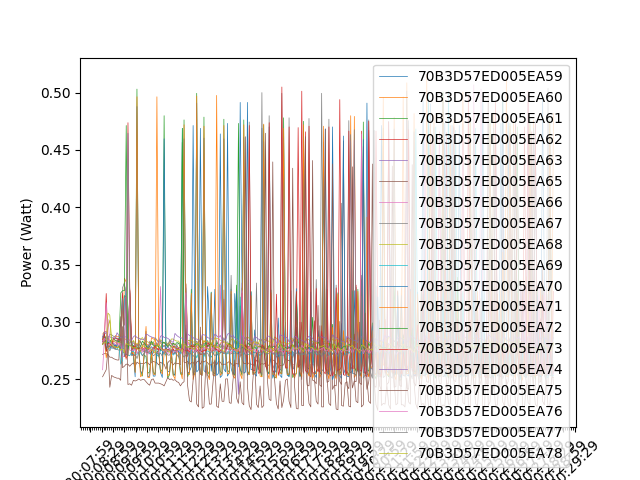

In [16]:
plt.figure()

for node_id, group in groups:
    idxs = np.linspace(0,len(group), 250, endpoint=False, dtype=int)

    subset = group["power"].iloc[idxs]
    plt.plot(subset.index, subset, label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Power (Watt)")
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))  # Set the major locator to display labels every 30 seconds
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))  # Set the minor locator to display labels at millisecond level
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S')) 
#plt.gca().xaxis.set_minor_formatter(DateFormatter('%S.%f'))  
plt.legend()
plt.show()

In [17]:
groups["power"].get_group(deveui)

timestamp
2024-05-06 20:08:31.256931    0.282648
2024-05-06 20:08:31.258060    0.280817
2024-05-06 20:08:31.259159    0.280817
2024-05-06 20:08:31.260257    0.281427
2024-05-06 20:08:31.261386    0.283259
                                ...   
2024-05-06 20:28:37.312516    0.257008
2024-05-06 20:28:37.313615    0.258840
2024-05-06 20:28:37.314744    0.258229
2024-05-06 20:28:37.315842    0.257008
2024-05-06 20:28:37.316941    0.259450
Name: power, Length: 1087026, dtype: float64

## finding sync signals

In [18]:
BLINK_HIGH_MS = 200
BLINK_PRE_MS = 100
BLINK_POST_MS = 100

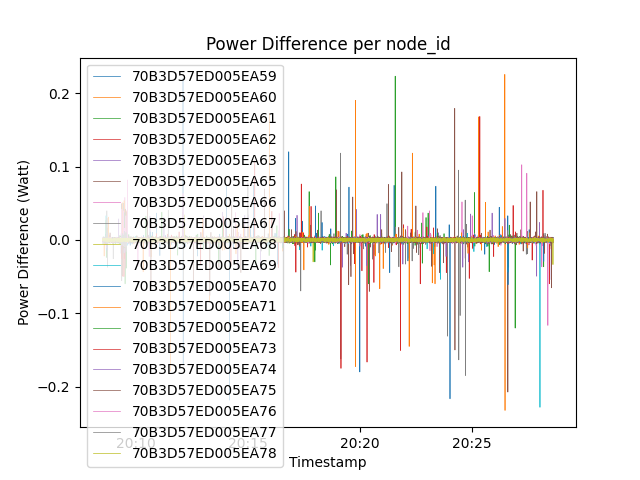

In [19]:
#diff of each group
power_consumption['power_diff'] = groups["power"].diff()

# single node
power_single = power_consumption[(power_consumption["node_id"] ==deveui)]
plt.figure()
for node_id, group in power_consumption.groupby("node_id"):
    idxs = np.linspace(0,len(group), 10000, endpoint=False, dtype=int) # there are comparatively few but big jumps, so hard to see when just taking "random" indexes
    subset = group["power_diff"].iloc[idxs]
    plt.plot(subset.index, subset, label=node_id, linewidth=0.5)
plt.title("Power Difference per node_id")
plt.xlabel("Timestamp")
plt.ylabel("Power Difference (Watt)")
plt.legend()
plt.show()

In [20]:
rising_edge = power_consumption[power_consumption["power_diff"] > 0.1].copy()
rising_edge.loc[:,'direction'] = 'rising'
falling_edge = power_consumption[power_consumption["power_diff"] < -0.1].copy()
falling_edge.loc[:,'direction'] = 'falling'
edges = pd.concat([rising_edge, falling_edge], verify_integrity=True)
edges.sort_index(inplace=True)
edges.head()

,power,current,voltage,node_id,power_diff,direction
timestamp,,,,,,
2024-05-06 20:09:32.896254,0.426720,0.087420,4.87875,70B3D57ED005EA72,0.147735,rising
2024-05-06 20:09:33.097250,0.275323,0.056383,4.87750,70B3D57ED005EA72,-0.177036,falling
2024-05-06 20:09:33.268118,0.479831,0.098896,4.85375,70B3D57ED005EA69,0.205119,rising
2024-05-06 20:09:33.290916,0.466400,0.096894,4.81125,70B3D57ED005EA65,0.197793,rising
2024-05-06 20:09:33.299375,0.452970,0.092987,4.87375,70B3D57ED005EA72,0.175206,rising


In [21]:
# populate edges with next direction and timestamps to later filter out edges that are too close to each other.
# need the index as dedicated column for this to be possible as a groupby transformation
edges['timestamp'] = edges.index.copy()
edges['next_direction'] = edges.groupby('node_id')['direction'].shift(-1)
edges['next_timestamp'] = edges.groupby('node_id')['timestamp'].shift(-1)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-05-06 20:09:32.896254,0.426720,0.087420,4.87875,70B3D57ED005EA72,0.147735,rising,2024-05-06 20:09:32.896254,falling,2024-05-06 20:09:33.097250
2024-05-06 20:09:33.097250,0.275323,0.056383,4.87750,70B3D57ED005EA72,-0.177036,falling,2024-05-06 20:09:33.097250,rising,2024-05-06 20:09:33.299375
2024-05-06 20:09:33.268118,0.479831,0.098896,4.85375,70B3D57ED005EA69,0.205119,rising,2024-05-06 20:09:33.268118,falling,2024-05-06 20:09:33.468778
2024-05-06 20:09:33.290916,0.466400,0.096894,4.81125,70B3D57ED005EA65,0.197793,rising,2024-05-06 20:09:33.290916,falling,2024-05-06 20:09:33.490875
2024-05-06 20:09:33.299375,0.452970,0.092987,4.87375,70B3D57ED005EA72,0.175206,rising,2024-05-06 20:09:33.299375,falling,2024-05-06 20:09:33.499273


In [22]:
# now to filter out edges that are too close to each other or too far apart. We add 10% tolerance

# filter out edges that are too close to each other or too far apart. We add 10% tolerance
edges = edges[(edges['direction'] == "rising") & (edges['next_direction'] == "falling") & ((edges['next_timestamp'] - edges.index < pd.Timedelta(milliseconds=BLINK_HIGH_MS + (BLINK_HIGH_MS/10)))  & (edges['next_timestamp'] - edges.index > pd.Timedelta(milliseconds=BLINK_HIGH_MS - (BLINK_HIGH_MS/10))))]
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp
timestamp,,,,,,,,,
2024-05-06 20:09:32.896254,0.426720,0.087420,4.87875,70B3D57ED005EA72,0.147735,rising,2024-05-06 20:09:32.896254,falling,2024-05-06 20:09:33.097250
2024-05-06 20:09:33.268118,0.479831,0.098896,4.85375,70B3D57ED005EA69,0.205119,rising,2024-05-06 20:09:33.268118,falling,2024-05-06 20:09:33.468778
2024-05-06 20:09:33.290916,0.466400,0.096894,4.81125,70B3D57ED005EA65,0.197793,rising,2024-05-06 20:09:33.290916,falling,2024-05-06 20:09:33.490875
2024-05-06 20:09:33.299375,0.452970,0.092987,4.87375,70B3D57ED005EA72,0.175206,rising,2024-05-06 20:09:33.299375,falling,2024-05-06 20:09:33.499273
2024-05-06 20:09:33.671727,0.499366,0.102779,4.85500,70B3D57ED005EA69,0.108054,rising,2024-05-06 20:09:33.671727,falling,2024-05-06 20:09:33.871258


In [23]:
## add sync signal start and end times
edges.loc[:, 'sync_start'] = edges.index - pd.Timedelta(milliseconds=100)
edges.loc[:, 'sync_end'] = edges.next_timestamp + pd.Timedelta(milliseconds=100)
edges.head()

,power,current,voltage,node_id,power_diff,direction,timestamp,next_direction,next_timestamp,sync_start,sync_end
timestamp,,,,,,,,,,,
2024-05-06 20:09:32.896254,0.426720,0.087420,4.87875,70B3D57ED005EA72,0.147735,rising,2024-05-06 20:09:32.896254,falling,2024-05-06 20:09:33.097250,2024-05-06 20:09:32.796254,2024-05-06 20:09:33.197250
2024-05-06 20:09:33.268118,0.479831,0.098896,4.85375,70B3D57ED005EA69,0.205119,rising,2024-05-06 20:09:33.268118,falling,2024-05-06 20:09:33.468778,2024-05-06 20:09:33.168118,2024-05-06 20:09:33.568778
2024-05-06 20:09:33.290916,0.466400,0.096894,4.81125,70B3D57ED005EA65,0.197793,rising,2024-05-06 20:09:33.290916,falling,2024-05-06 20:09:33.490875,2024-05-06 20:09:33.190916,2024-05-06 20:09:33.590875
2024-05-06 20:09:33.299375,0.452970,0.092987,4.87375,70B3D57ED005EA72,0.175206,rising,2024-05-06 20:09:33.299375,falling,2024-05-06 20:09:33.499273,2024-05-06 20:09:33.199375,2024-05-06 20:09:33.599273
2024-05-06 20:09:33.671727,0.499366,0.102779,4.85500,70B3D57ED005EA69,0.108054,rising,2024-05-06 20:09:33.671727,falling,2024-05-06 20:09:33.871258,2024-05-06 20:09:33.571727,2024-05-06 20:09:33.971258


Node 70B3D57ED005EA68 has no edges
Node 70B3D57ED005EA74 has no edges
Node 70B3D57ED005EA78 has no edges


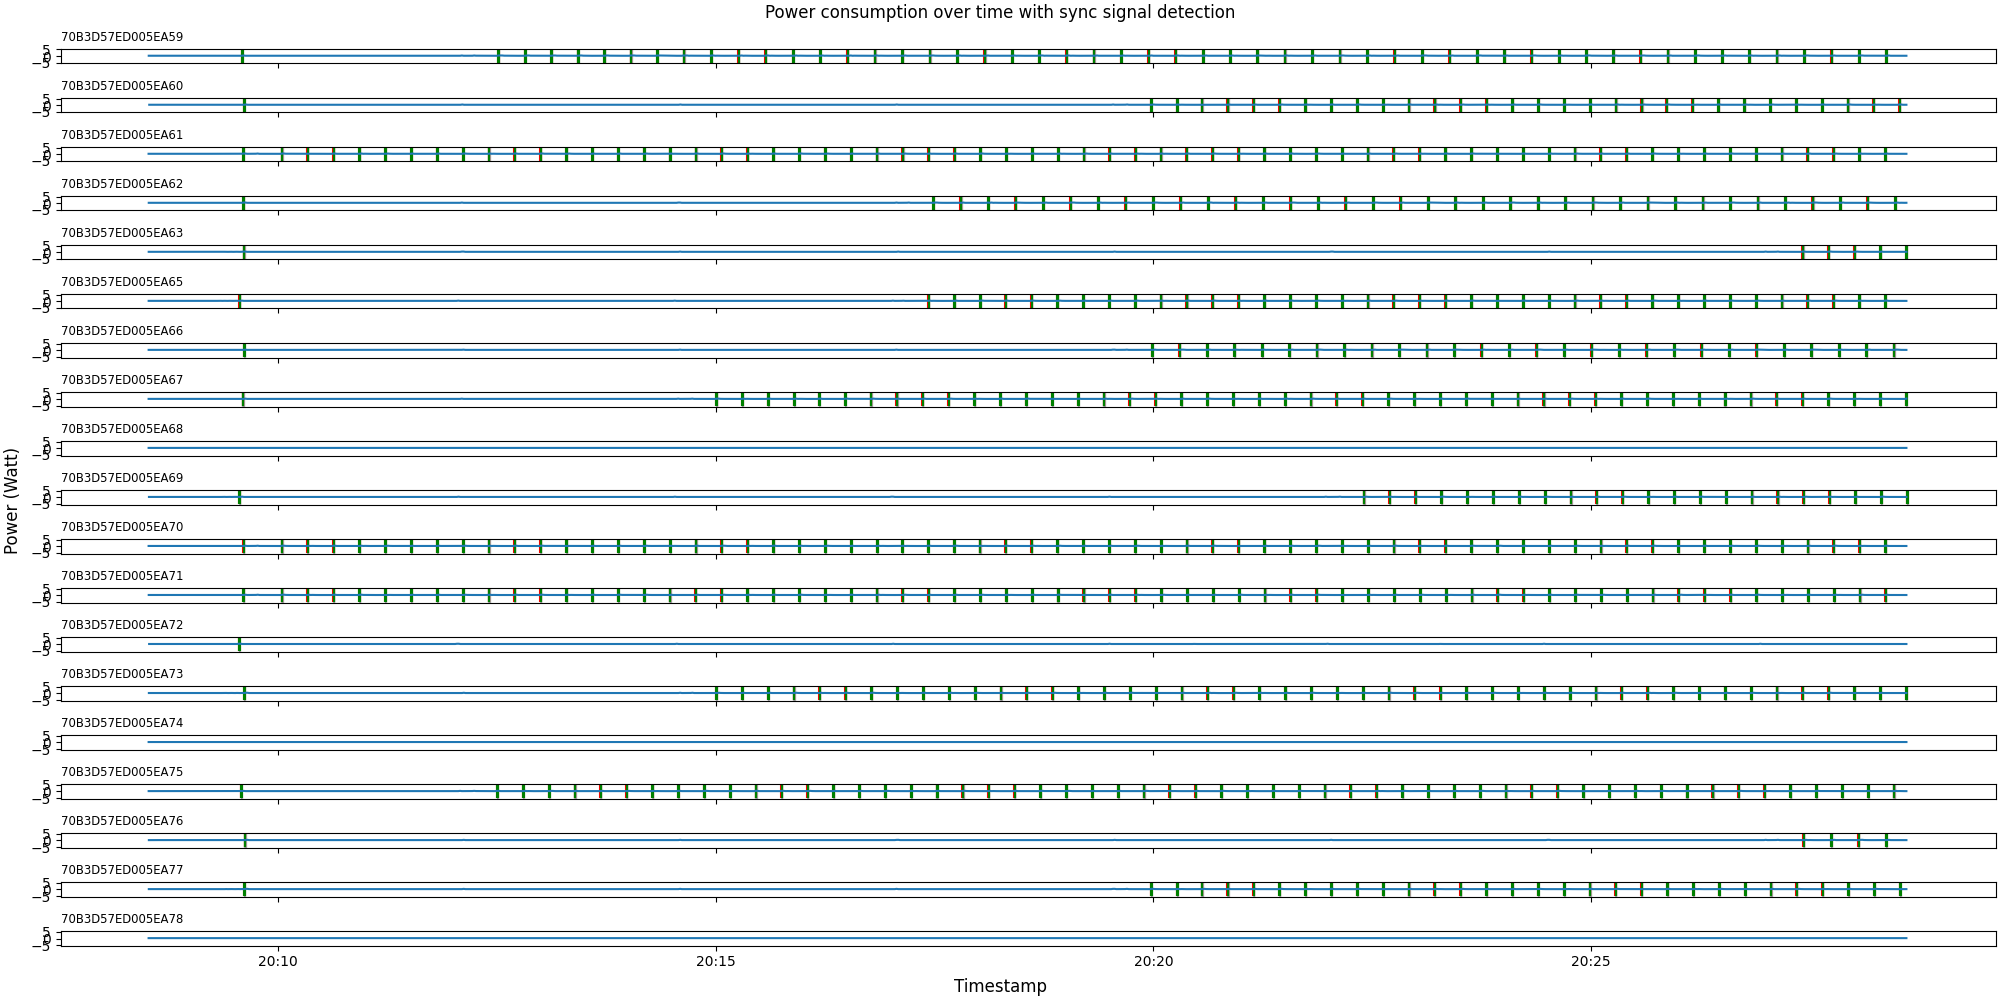

In [24]:
groups_by_node_id = power_consumption.groupby('node_id')
edges_by_node_id = edges.groupby('node_id')

fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, layout='constrained', figsize=(20, 10))
fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with sync signal detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in edges_by_node_id.groups:
        edges_grouped = edges_by_node_id.get_group(node_id)
        ax.vlines(edges_grouped['timestamp'], ymin=-5, ymax=5, color='red')
        ax.vlines(edges_grouped['next_timestamp'], ymin=-5, ymax=5, color='green')
        for row in edges_by_node_id.get_group(node_id).itertuples():
            ax.axvspan(row.sync_start, row.sync_end, color='grey', alpha=0.5)

    else:
        print(f"Node {node_id} has no edges")
    idxs = np.linspace(0, len(group), endpoint=False, num=1000, dtype=int)
    subset = group["power"].iloc[idxs]
    ax.plot(subset.index, subset, label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')
plt.show()

In [25]:
# every loop starts with 2 sync signals right after each other
# find all sync signals where the next start is very close to previous end
grouped = edges.groupby('node_id')
edges['next_sync_start'] = grouped['sync_start'].shift(-1)
edges['next_sync_end'] = grouped['sync_end'].shift(-1)
loops = edges[abs(edges['sync_end'] - edges['next_sync_start']) < pd.Timedelta(milliseconds=500)][['node_id', 'sync_start', 'next_sync_end']].copy()
loops.rename(columns={'sync_start': 'loop_signal_start', 'next_sync_end': 'loop_signal_end'}, inplace=True)
loops['loop_num'] = loops.groupby('node_id').cumcount()
loops[['node_id','loop_num']]


,node_id,loop_num
timestamp,,
2024-05-06 20:09:32.896254,70B3D57ED005EA72,0
2024-05-06 20:09:33.268118,70B3D57ED005EA69,0
2024-05-06 20:09:33.290916,70B3D57ED005EA65,0
2024-05-06 20:09:34.414114,70B3D57ED005EA75,0
2024-05-06 20:09:34.969762,70B3D57ED005EA59,0
...,...,...
2024-05-06 20:28:31.621515,70B3D57ED005EA77,30
2024-05-06 20:28:35.676280,70B3D57ED005EA67,47
2024-05-06 20:28:35.769775,70B3D57ED005EA73,47


Node 70B3D57ED005EA68 has no loops
Node 70B3D57ED005EA74 has no loops
Node 70B3D57ED005EA78 has no loops


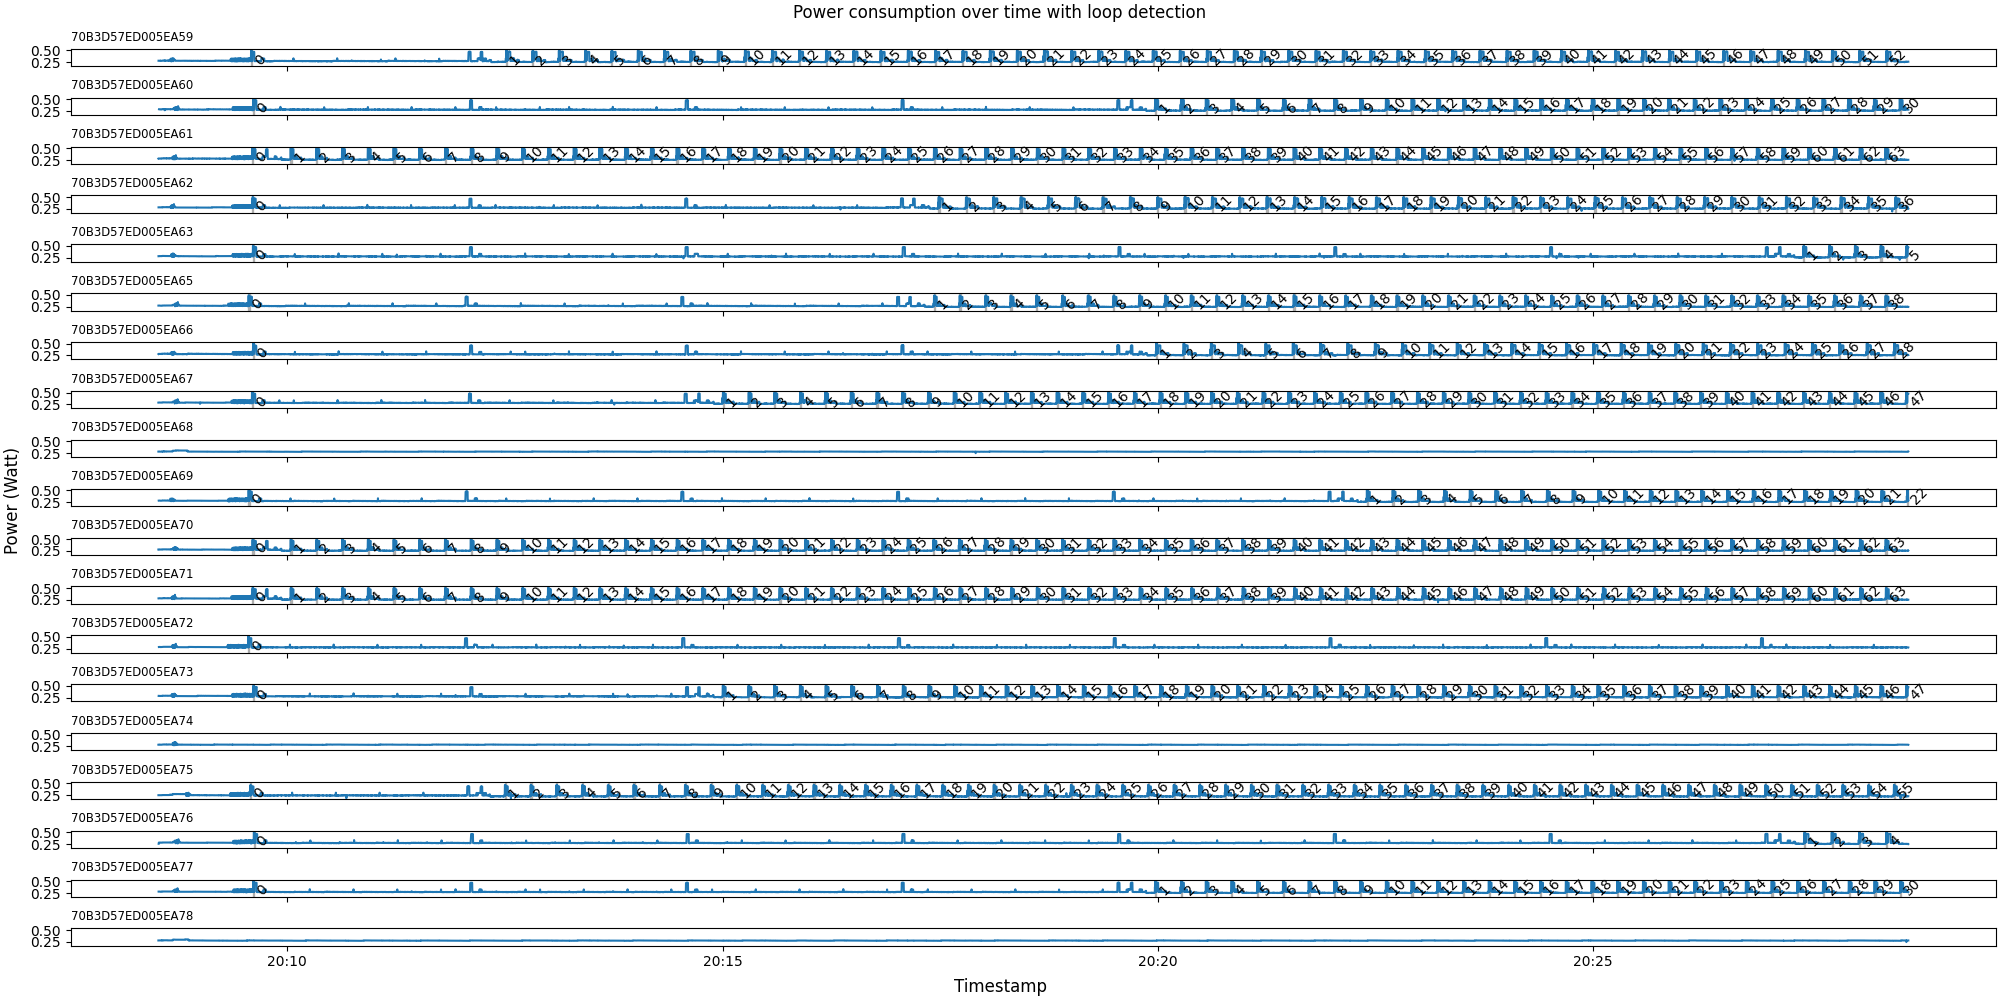

In [26]:

groups_by_node_id = power_consumption.groupby('node_id')
loops_by_node_id = loops.groupby('node_id')
fig, axs = plt.subplots(len(groups_by_node_id), 1, sharex=True, sharey=True, figsize=(20, 10), layout='constrained')

fig.supxlabel("Timestamp")
fig.supylabel("Power (Watt)")
fig.suptitle("Power consumption over time with loop detection")
for ((node_id, group), ax) in zip(groups_by_node_id, axs):
    if node_id in loops_by_node_id.groups:
        loops_group = loops_by_node_id.get_group(node_id)
        for row in loops_group.itertuples():
            ax.axvspan(row.loop_signal_start, row.loop_signal_end, color='tab:gray', alpha=0.5, label="loop signal")
            ax.text(row.loop_signal_end, 0.2, f"{row.loop_num}", rotation=45)
    else:
        print(f"Node {node_id} has no loops")
    idxs = np.linspace(0, len(group), endpoint=False, num=10000, dtype=int)
    subset = group["power"].iloc[idxs]

    ax.plot(subset.index, subset,label=node_id)
    ax.set_title(node_id, fontsize='small', loc='left')

plt.show()

In [27]:
# 'TIMINGS> Loop: 0, Sync: 806 ms, Load: 40 ms, sensor init: 10 ms, env init: 0 ms, net init: 5216 ms, Collect: -1 ms, Exec: -1 ms, Send: 5119 ms, save config: 2646 ms, Sleep: 9 s\n'
query = """
SELECT 
    node_id,
    timestamp,
    regexp_extract(message, 'Loop: (-?[0-9]+)',1) as loop_num,
    regexp_extract(message, '.*Sync: (-?[0-9]+)',1) as sync_time_ms,
    regexp_extract(message, '.*Load: (-?[0-9]+)',1) as load_time_ms,
    regexp_extract(message, '.*sensor init: (-?[0-9]+)',1) as sensor_init_time_ms,
    regexp_extract(message, '.*env init: (-?[0-9]+)',1) as env_init_time_ms,
    regexp_extract(message, '.*net init: (-?[0-9]+)',1) as net_init_time_ms,
    --regexp_extract(message, '.*Listen: (-?[0-9]+)',1) as listen_time_ms,
    regexp_extract(message, '.*Collect: (-?[0-9]+)',1) as collect_time_ms,
    regexp_extract(message, '.*Exec: (-?[0-9]+)',1) as exec_time_ms,
    regexp_extract(message, '.*Send: (-?[0-9]+)',1) as send_time_ms,
    regexp_extract(message, '.*save config: (-?[0-9]+)',1) as save_config_time_ms,
    regexp_extract(message, '.*Sleep: (-?[0-9]+)',1) as sleep_time_s
FROM expdb.Trace
WHERE message LIKE 'TIMINGS>%'
"""
timings = %sql {{query}}
timings['node_id'].unique()

Running query in 'duckdb'

array(['70B3D57ED005EA61', '70B3D57ED005EA70', '70B3D57ED005EA71',
       '70B3D57ED005EA75', '70B3D57ED005EA59', '70B3D57ED005EA73',
       '70B3D57ED005EA67', '70B3D57ED005EA65', '70B3D57ED005EA62',
       '70B3D57ED005EA77', '70B3D57ED005EA60', '70B3D57ED005EA66',
       '70B3D57ED005EA69', '70B3D57ED005EA63', '70B3D57ED005EA76'],
      dtype=object)

In [28]:
# since duckdb return all columns as object we need to change types before we can merge
timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']] = timings[['loop_num', 'sync_time_ms', 'load_time_ms', 'sensor_init_time_ms', 'env_init_time_ms', 'net_init_time_ms', 'collect_time_ms', 'exec_time_ms', 'send_time_ms', 'save_config_time_ms', 'sleep_time_s']].apply(pd.to_numeric)

# .. and merge. here we need to reset index first, since df.merge doesnt preserve index
loops = loops.reset_index().merge(timings, on=['node_id', 'loop_num']).set_index('loop_signal_start')
loops.head()

,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,collect_time_ms,exec_time_ms,send_time_ms,save_config_time_ms,sleep_time_s
loop_signal_start,,,,,,,,,,,,,,,
2024-05-06 20:09:33.168118,2024-05-06 20:09:33.268118,70B3D57ED005EA69,2024-05-06 20:09:33.971258,0,2024-05-06 20:22:17.704546,805,22,25,0,752901,-1,-1,8071,697,6
2024-05-06 20:09:33.190916,2024-05-06 20:09:33.290916,70B3D57ED005EA65,2024-05-06 20:09:33.994240,0,2024-05-06 20:17:19.340382,805,22,25,0,454512,-1,-1,8072,700,6
2024-05-06 20:09:34.314114,2024-05-06 20:09:34.414114,70B3D57ED005EA75,2024-05-06 20:09:35.117071,0,2024-05-06 20:12:19.676054,806,21,26,0,158002,-1,-1,3890,600,10
2024-05-06 20:09:34.869762,2024-05-06 20:09:34.969762,70B3D57ED005EA59,2024-05-06 20:09:35.673299,0,2024-05-06 20:12:20.510322,806,21,26,0,157445,-1,-1,3894,1425,10
2024-05-06 20:09:35.502580,2024-05-06 20:09:35.602580,70B3D57ED005EA67,2024-05-06 20:09:36.304897,0,2024-05-06 20:14:53.908922,805,22,25,0,306768,-1,-1,8073,704,6


In [29]:

loops["start_time"] = loops.index
loops["sync_start"] = loops["start_time"]
loops["sync_end"] = loops["sync_start"] + pd.to_timedelta(loops["sync_time_ms"], unit="ms")
loops["load_start"] = loops["sync_end"]
loops["load_end"] = loops["load_start"] + pd.to_timedelta(loops["load_time_ms"], unit="ms")
loops["sensor_init_start"] = loops["load_end"]
loops["sensor_init_end"] = loops["sensor_init_start"] + pd.to_timedelta(loops["sensor_init_time_ms"], unit="ms")
loops["env_init_start"] = loops["sensor_init_end"]
loops["env_init_end"] = loops["env_init_start"] + pd.to_timedelta(loops["env_init_time_ms"], unit="ms")
loops["net_init_start"] = loops["env_init_end"]
loops["net_init_end"] = loops["net_init_start"] + pd.to_timedelta(loops["net_init_time_ms"], unit="ms")
loops["collect_time_start"] = loops["net_init_end"]
loops["collect_time_end"] = loops["collect_time_start"] +pd.to_timedelta(loops["collect_time_ms"], unit="ms")
loops["exec_start"] = loops["collect_time_end"]
loops["exec_end"] = loops["exec_start"] + pd.to_timedelta(loops["exec_time_ms"], unit="ms")
loops["send_start"] = loops["exec_end"]
loops["send_end"] = loops["send_start"] +pd.to_timedelta(loops["send_time_ms"], unit="ms")
loops["save_config_start"] = loops["send_end"]
loops["save_config_end"] = loops["save_config_start"] + pd.to_timedelta(loops["save_config_time_ms"], unit="ms")
loops["sleep_start"] = loops["save_config_end"]
loops["sleep_end"] = loops["sleep_start"] + pd.to_timedelta(loops["sleep_time_s"], unit="s")

loops.replace(-1,0) # remove -1 values. They show up if the time measurement is not available



,timestamp_x,node_id,loop_signal_end,loop_num,timestamp_y,sync_time_ms,load_time_ms,sensor_init_time_ms,env_init_time_ms,net_init_time_ms,...,collect_time_start,collect_time_end,exec_start,exec_end,send_start,send_end,save_config_start,save_config_end,sleep_start,sleep_end
loop_signal_start,,,,,,,,,,,,,,,,,,,,,
2024-05-06 20:09:33.168118,2024-05-06 20:09:33.268118,70B3D57ED005EA69,2024-05-06 20:09:33.971258,0,2024-05-06 20:22:17.704546,805,22,25,0,752901,...,2024-05-06 20:22:06.921118,2024-05-06 20:22:06.920118,2024-05-06 20:22:06.920118,2024-05-06 20:22:06.919118,2024-05-06 20:22:06.919118,2024-05-06 20:22:14.990118,2024-05-06 20:22:14.990118,2024-05-06 20:22:15.687118,2024-05-06 20:22:15.687118,2024-05-06 20:22:21.687118
2024-05-06 20:09:33.190916,2024-05-06 20:09:33.290916,70B3D57ED005EA65,2024-05-06 20:09:33.994240,0,2024-05-06 20:17:19.340382,805,22,25,0,454512,...,2024-05-06 20:17:08.554916,2024-05-06 20:17:08.553916,2024-05-06 20:17:08.553916,2024-05-06 20:17:08.552916,2024-05-06 20:17:08.552916,2024-05-06 20:17:16.624916,2024-05-06 20:17:16.624916,2024-05-06 20:17:17.324916,2024-05-06 20:17:17.324916,2024-05-06 20:17:23.324916
2024-05-06 20:09:34.314114,2024-05-06 20:09:34.414114,70B3D57ED005EA75,2024-05-06 20:09:35.117071,0,2024-05-06 20:12:19.676054,806,21,26,0,158002,...,2024-05-06 20:12:13.169114,2024-05-06 20:12:13.168114,2024-05-06 20:12:13.168114,2024-05-06 20:12:13.167114,2024-05-06 20:12:13.167114,2024-05-06 20:12:17.057114,2024-05-06 20:12:17.057114,2024-05-06 20:12:17.657114,2024-05-06 20:12:17.657114,2024-05-06 20:12:27.657114
2024-05-06 20:09:34.869762,2024-05-06 20:09:34.969762,70B3D57ED005EA59,2024-05-06 20:09:35.673299,0,2024-05-06 20:12:20.510322,806,21,26,0,157445,...,2024-05-06 20:12:13.167762,2024-05-06 20:12:13.166762,2024-05-06 20:12:13.166762,2024-05-06 20:12:13.165762,2024-05-06 20:12:13.165762,2024-05-06 20:12:17.059762,2024-05-06 20:12:17.059762,2024-05-06 20:12:18.484762,2024-05-06 20:12:18.484762,2024-05-06 20:12:28.484762
2024-05-06 20:09:35.502580,2024-05-06 20:09:35.602580,70B3D57ED005EA67,2024-05-06 20:09:36.304897,0,2024-05-06 20:14:53.908922,805,22,25,0,306768,...,2024-05-06 20:14:43.122580,2024-05-06 20:14:43.121580,2024-05-06 20:14:43.121580,2024-05-06 20:14:43.120580,2024-05-06 20:14:43.120580,2024-05-06 20:14:51.193580,2024-05-06 20:14:51.193580,2024-05-06 20:14:51.897580,2024-05-06 20:14:51.897580,2024-05-06 20:14:57.897580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06 20:28:21.930840,2024-05-06 20:28:22.030840,70B3D57ED005EA59,2024-05-06 20:28:22.734438,52,2024-05-06 20:28:30.571191,806,22,25,0,57,...,2024-05-06 20:28:22.840840,2024-05-06 20:28:22.840840,2024-05-06 20:28:22.840840,2024-05-06 20:28:22.961840,2024-05-06 20:28:22.961840,2024-05-06 20:28:26.993840,2024-05-06 20:28:26.993840,2024-05-06 20:28:28.254840,2024-05-06 20:28:28.254840,2024-05-06 20:28:38.254840
2024-05-06 20:28:21.950003,2024-05-06 20:28:22.050003,70B3D57ED005EA76,2024-05-06 20:28:22.752198,4,2024-05-06 20:28:30.597820,806,22,25,0,51,...,2024-05-06 20:28:22.854003,2024-05-06 20:28:22.854003,2024-05-06 20:28:22.854003,2024-05-06 20:28:22.975003,2024-05-06 20:28:22.975003,2024-05-06 20:28:27.008003,2024-05-06 20:28:27.008003,2024-05-06 20:28:28.283003,2024-05-06 20:28:28.283003,2024-05-06 20:28:38.283003
2024-05-06 20:28:27.171579,2024-05-06 20:28:27.271579,70B3D57ED005EA75,2024-05-06 20:28:27.974567,55,2024-05-06 20:28:34.709869,806,22,25,0,52,...,2024-05-06 20:28:28.076579,2024-05-06 20:28:28.075579,2024-05-06 20:28:28.075579,2024-05-06 20:28:28.074579,2024-05-06 20:28:28.074579,2024-05-06 20:28:32.152579,2024-05-06 20:28:32.152579,2024-05-06 20:28:32.683579,2024-05-06 20:28:32.683579,2024-05-06 20:28:42.683579


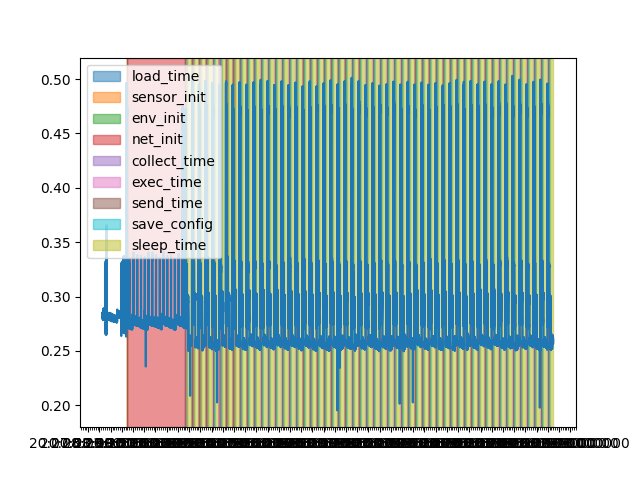

In [30]:
node_id = "70B3D57ED005EA59"
timing_data = loops[loops["node_id"] == node_id]
power_data = power_consumption[power_consumption["node_id"] == node_id]

plt.figure()
plt.plot(power_data.index, power_data["power"])
for row in timing_data.itertuples():
    plt.axvspan(row.load_start, row.load_end, color='tab:blue', alpha=0.5, label="load_time")
    plt.axvspan(row.sensor_init_start, row.sensor_init_end, color='tab:orange', alpha=0.5, label="sensor_init")
    plt.axvspan(row.env_init_start, row.env_init_end, color='tab:green', alpha=0.5, label="env_init")
    plt.axvspan(row.net_init_start, row.net_init_end, color='tab:red', alpha=0.5, label="net_init")
    plt.axvspan(row.collect_time_start, row.collect_time_end, color='tab:purple', alpha=0.5, label="collect_time")
    plt.axvspan(row.exec_start, row.exec_end, color='tab:pink', alpha=0.5, label="exec_time")
    plt.axvspan(row.send_start, row.send_end, color='tab:brown', alpha=0.5, label="send_time")
    plt.axvspan(row.save_config_start, row.save_config_end, color='tab:cyan', alpha=0.5, label="save_config")
    plt.axvspan(row.sleep_start, row.sleep_end, color='tab:olive', alpha=0.5, label="sleep_time")
# this to remove duplicate labels https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.gca().xaxis.set_major_locator(SecondLocator(interval=30))
plt.gca().xaxis.set_minor_locator(SecondLocator(interval=5))

plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))  # Set the date format for the tick labels
plt.show()


## Add events if any

In [31]:
# get all relevant frame-events
%sql send_frame_start << select * from expdb.Trace WHERE message LIKE '%send frame%'
%sql send_frame_end << select * from expdb.Trace WHERE message LIKE '%Transmission completed%'
%sql receive_frame_start << select * from expdb.Trace WHERE message LIKE '%RX started%'
%sql receive_frame_end << select * from expdb.Trace WHERE message LIKE '%received something%'

print(f"{len(send_frame_start)} send frame start events. {len(send_frame_end)} end events. {len(receive_frame_start)} receive frame start events. {len(receive_frame_end)} end events.")

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

Running query in 'duckdb'

0 send frame start events. 0 end events. 0 receive frame start events. 0 end events.


In [32]:
#drop first row of send_frame_end and receive_frame_start since thats from the join procedure
send_frame_end = send_frame_end.iloc[1:]
receive_frame_start = receive_frame_start.iloc[1:]

# confirm the 2 pairs of start/end all have the same length
assert len(send_frame_start) == len(send_frame_end), f"send frame event mismatch. start {len(send_frame_start)}, end { len(send_frame_end)}"
assert len(receive_frame_start) == len(receive_frame_end), f"receive frame event mismatch  {len(receive_frame_start)}, end { len(receive_frame_end)}"

In [33]:
# add send and receive columns to plot
#TODO: update this to support more nodes
# for send_start_row, send_end_row in zip(send_frame_start.itertuples(), send_frame_end.itertuples()):
#     start_time = send_start_row.timestamp
#     end_time = send_end_row.timestamp
#     plt.axvspan(start_time, end_time, color='tab:pink', alpha=0.5, label="send_events")

# for receive_frame_start, receive_frame_end in zip(receive_frame_start.itertuples(), receive_frame_end.itertuples()):
#     start_time = receive_frame_start.timestamp
#     end_time = receive_frame_end.timestamp
#     plt.axvspan(start_time, end_time, color='tab:brown', alpha=0.5, label="receive_events")


# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()

In [34]:
%sql SELECT * from expdb.Content_Message

Running query in 'duckdb'

,content_message_id,frame_counter,frame_port,frame_payload
0,1,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
1,2,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
2,3,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
3,4,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
4,5,-1,1,CmwKagpoCmQKAggBCgIQAAoCCAAKAhAICgIICgoCCAEKAh...
...,...,...,...,...
246,259,46,2,PDM=
247,260,21,2,PDM=
248,261,38,2,PDM=
249,262,47,2,PDM=


In [35]:
%%sql
SELECT
    through_gateway,
    gateway_received_at,
    app_received_at,
    rssi,
    snr,
    bandwidth,
    frequency,
    consumed_airtime_s,
    spreading_factor,
    coding_rate,
    frame_counter,
    frame_port,
    frame_payload,
    from_base64(frame_payload) as decoded_payload,
    related_node,
    network_received_at
FROM
    expdb.Uplink_Message,
    expdb.Content_Message,
    expdb.Message 
WHERE
    Uplink_Message.uplink_message_id = Message.message_id AND
    Content_Message.content_message_id = Message.message_id

Running query in 'duckdb'

,through_gateway,gateway_received_at,app_received_at,rssi,snr,bandwidth,frequency,consumed_airtime_s,spreading_factor,coding_rate,frame_counter,frame_port,frame_payload,decoded_payload,related_node,network_received_at
0,gw-tetech-test,2024-05-06 18:10:04,2024-05-06 18:10:04.594047,-111,-7.50,125000,868300000,1.155072,SF12,4/5,1,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-05-06 18:10:04.386428
1,iot-lab-saclay-gateway,2024-05-06 18:10:22,2024-05-06 18:10:22.463970,-27,7.75,125000,868100000,1.155072,SF12,4/5,2,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-05-06 18:10:22.255556
2,gw-tetech-test,2024-05-06 18:10:39,2024-05-06 18:10:40.059230,-122,-7.00,125000,868100000,1.155072,SF12,4/5,3,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-05-06 18:10:39.852098
3,iot-lab-saclay-gateway,2024-05-06 18:11:15,2024-05-06 18:11:15.726908,-25,7.00,125000,868100000,1.155072,SF12,4/5,5,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-05-06 18:11:15.519377
4,iot-lab-saclay-gateway,2024-05-06 18:11:33,2024-05-06 18:11:33.453233,-29,8.75,125000,868100000,1.155072,SF12,4/5,6,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-05-06 18:11:33.245823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,iot-lab-saclay-gateway,2024-05-06 18:26:51,2024-05-06 18:26:51.785354,-34,2.50,125000,868100000,1.155072,SF12,4/5,41,2,PDM=,"[60, 51]",70B3D57ED005EA73,2024-05-06 18:26:51.577614
183,iot-lab-saclay-gateway,2024-05-06 18:27:15,2024-05-06 18:27:16.105877,-93,-4.00,125000,867100000,1.646592,SF12,4/5,32,2,Cg4SAyDOExIDINQlEgJABg==,"[10, 14, 18, 3, 32, 206, 19, 18, 3, 32, 212, 3...",70B3D57ED005EA62,2024-05-06 18:27:15.896710
184,gw-tetech-test,2024-05-06 18:16:16,2024-05-06 18:16:17.056419,-121,-4.00,125000,868300000,1.155072,SF12,4/5,22,2,PDM=,"[60, 51]",70B3D57ED005EA70,2024-05-06 18:16:16.849042
185,iot-lab-saclay-gateway,2024-05-06 18:28:19,2024-05-06 18:28:20.400827,-34,7.75,125000,868300000,1.155072,SF12,4/5,46,2,PDM=,"[60, 51]",70B3D57ED005EA73,2024-05-06 18:28:20.192065


## experiment stats
with sync signals and events mapped we can see some stats on the experiments

In [36]:
%%sql
select * from expdb.Node

Running query in 'duckdb'

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board,failed
0,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
1,70B3D57ED005EA60,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
2,70B3D57ED005EA61,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
3,70B3D57ED005EA62,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
4,70B3D57ED005EA63,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
5,70B3D57ED005EA64,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1
6,70B3D57ED005EA65,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
7,70B3D57ED005EA66,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
8,70B3D57ED005EA67,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,0
9,70B3D57ED005EA68,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1,1


In [37]:
loops.groupby('node_id')['loop_num'].max()

node_id
70B3D57ED005EA59    52
70B3D57ED005EA60    29
70B3D57ED005EA61    63
70B3D57ED005EA62    36
70B3D57ED005EA63     4
70B3D57ED005EA65    38
70B3D57ED005EA66    28
70B3D57ED005EA67    46
70B3D57ED005EA69    21
70B3D57ED005EA70    63
70B3D57ED005EA71    63
70B3D57ED005EA73    46
70B3D57ED005EA75    55
70B3D57ED005EA76     4
70B3D57ED005EA77    29
Name: loop_num, dtype: int64

## Calculate Total Energy Consumed per region

In [38]:
np.sum((np.abs(np.diff(power_consumption.index.to_numpy())) / np.timedelta64(1, 's')) * power_consumption["power"].values[:-1])

13089.745487515052

In [39]:
#define function to calculate energy consumed

def calc_energy_consumed(df: pd.DataFrame):

    # create a copy of the dataframe with only index and power
    if len(df) == 0:
        return 0
    #     # ensure we only calculate for data frames containing data from a single node
    # assert len(df["node_id"].unique()) == 1, "energy consumption only supported for single node"

    # # assert df have columns "power" and index of "timestamp" type
    # assert "power" in df.columns, "power column not found"
    # assert isinstance(df.index, pd.DatetimeIndex), "index is not  of type pd.DatetimeIndex"
    times = df.index.array
    powers = df["power"].values

    #power["power_diff"] = power.diff().shift(-1) #  current - previous, shifted one back so it becomes next - current. i.e. current + diff = next
    time_diff= np.abs(np.diff(times)) # abs(next-current)
    time_diff_s = time_diff / np.timedelta64(1, 's') # get timediff in fractions of a second
    powers = powers[:-1] # drop last row since it has no next and doesnt match up with the time_diff
    return np.sum(powers * time_diff_s) # returns the sum of power times fractions of a second. Since power is in W and time_diff_s is in seconds it is in W*s or J


In [40]:
# loops contain the start and end times of each activity, so loop over loops and calculate the energy for each activity
def calc_energy_consumed_per_activity(series_loops: pd.Series) -> pd.Series:
    power_consumption_for_node = power_consumption[(power_consumption["node_id"] == series_loops["node_id"])]
    return pd.Series({
        "node_id": series_loops["node_id"],
        "loop_num": series_loops["loop_num"],
        "total": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["sleep_end"]]),
        "loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops.name:series_loops["loop_signal_end"]]),
        "total without loop signal": calc_energy_consumed(power_consumption_for_node.loc[series_loops["loop_signal_end"]:series_loops["sleep_end"]]),
        "load config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["load_start"]:series_loops["load_end"]]),
        "sensor init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sensor_init_start"]:series_loops["sensor_init_end"]]),
        "env init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["env_init_start"]:series_loops["env_init_end"]]),
        "net init": calc_energy_consumed(power_consumption_for_node.loc[series_loops["net_init_start"]:series_loops["net_init_end"]]),
        "sensor collect": calc_energy_consumed(power_consumption_for_node.loc[series_loops["collect_time_start"]:series_loops["collect_time_end"]]),
        "query execution": calc_energy_consumed(power_consumption_for_node.loc[series_loops["exec_start"]:series_loops["exec_end"]]),
        "send": calc_energy_consumed(power_consumption_for_node.loc[series_loops["send_start"]:series_loops["send_end"]]),
        "save config": calc_energy_consumed(power_consumption_for_node.loc[series_loops["save_config_start"]:series_loops["save_config_end"]]),
        "sleep": calc_energy_consumed(power_consumption_for_node.loc[series_loops["sleep_start"]:series_loops["sleep_end"]]),
    })
energy_consumed = loops.apply(calc_energy_consumed_per_activity, axis=1)
energy_consumed_summary = energy_consumed.describe()
energy_consumed_summary

,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.0,592.000000,592.0,592.000000,592.000000,592.000000,592.000000
mean,23.753378,7.566644,0.307392,7.258936,0.005805,0.007054,0.0,3.081617,0.0,0.007040,1.415384,0.189452,2.550476
std,16.333247,24.180074,0.007924,24.179759,0.000280,0.000327,0.0,24.160191,0.0,0.013976,0.168922,0.085703,0.205981
min,0.000000,2.837364,0.283623,2.549392,0.005230,0.006322,0.0,0.013027,0.0,0.000000,1.208570,0.130123,0.792957
25%,10.000000,4.448389,0.306800,4.140377,0.005558,0.006849,0.0,0.014437,0.0,0.000000,1.375045,0.145008,2.582623
50%,21.500000,4.478203,0.309709,4.167727,0.005805,0.007060,0.0,0.015967,0.0,0.000000,1.390902,0.146615,2.598302
75%,35.000000,4.588274,0.311671,4.273743,0.006075,0.007240,0.0,0.016241,0.0,0.000000,1.417604,0.151717,2.637895
max,63.000000,299.610875,0.320923,299.299250,0.006390,0.007750,0.0,294.983758,0.0,0.035389,2.540887,0.396852,2.681896


In [41]:
import scipy.stats as st
def calc_confidence_interval(series: pd.Series) -> pd.Series:
    assert "mean" in series.index, "mean not in index"
    assert "std" in series.index, "std not in index"
    if series["mean"] == 0 or series["std"] == 0:
        return pd.Series({
            "low": 0,
            "high": 0
        })
    low, high = st.norm.interval(0.95, loc=series["mean"], scale=series["std"])
    return pd.Series({
        "low": low,
        "high": high
    })



In [42]:
energy_consumed_summary

,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.0,592.000000,592.0,592.000000,592.000000,592.000000,592.000000
mean,23.753378,7.566644,0.307392,7.258936,0.005805,0.007054,0.0,3.081617,0.0,0.007040,1.415384,0.189452,2.550476
std,16.333247,24.180074,0.007924,24.179759,0.000280,0.000327,0.0,24.160191,0.0,0.013976,0.168922,0.085703,0.205981
min,0.000000,2.837364,0.283623,2.549392,0.005230,0.006322,0.0,0.013027,0.0,0.000000,1.208570,0.130123,0.792957
25%,10.000000,4.448389,0.306800,4.140377,0.005558,0.006849,0.0,0.014437,0.0,0.000000,1.375045,0.145008,2.582623
50%,21.500000,4.478203,0.309709,4.167727,0.005805,0.007060,0.0,0.015967,0.0,0.000000,1.390902,0.146615,2.598302
75%,35.000000,4.588274,0.311671,4.273743,0.006075,0.007240,0.0,0.016241,0.0,0.000000,1.417604,0.151717,2.637895
max,63.000000,299.610875,0.320923,299.299250,0.006390,0.007750,0.0,294.983758,0.0,0.035389,2.540887,0.396852,2.681896


In [43]:
errors = energy_consumed_summary.apply(calc_confidence_interval)
errors = np.abs(errors)
errors

,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
low,8.259197,39.825429,0.291861,40.132521,0.005256,0.006412,0,44.271487,0,0.020351,1.084303,0.021477,2.146760
high,55.765954,54.958718,0.322924,54.650394,0.006355,0.007695,0,50.434721,0,0.034432,1.746466,0.357428,2.954192


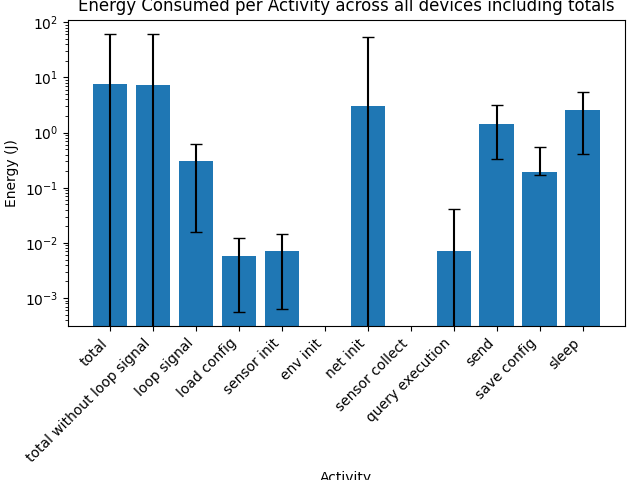

In [44]:
# plot barchart with stddev error bars
plt.figure()
to_plot = energy_consumed_summary[["total", "total without loop signal", "loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
errors = errors[["total", "total without loop signal", "loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors, log=True,capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices including totals")
plt.show()

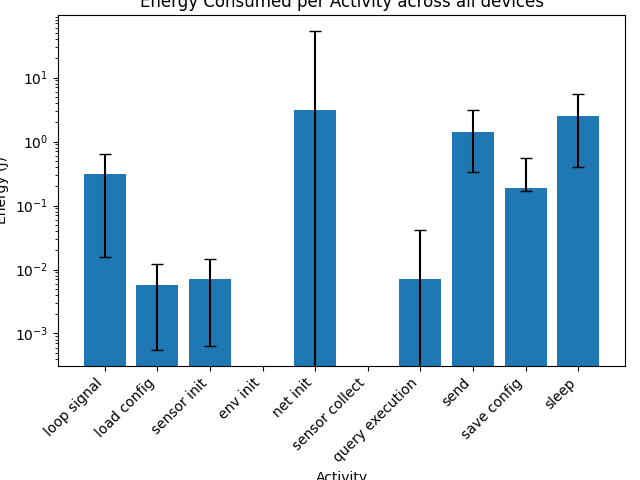

In [45]:
# plot barchart without totals 
plt.figure()
to_plot = energy_consumed_summary[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
errors = errors[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors, log=True, capsize=4)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices")
plt.show()

In [46]:
# plot barchart without totals and without the 0th loop
# recalc summary without 0 loops
without_0th_loop = loops[loops["loop_num"] > 0].apply(calc_energy_consumed_per_activity, axis=1)
without_0th_loop_summary = without_0th_loop.describe()

In [47]:
errors_with_0th_loop = without_0th_loop_summary.apply(calc_confidence_interval)
errors_with_0th_loop = np.abs(errors_with_0th_loop)
errors_with_0th_loop

,loop_num,total,loop signal,total without loop signal,load config,sensor init,env init,net init,sensor collect,query execution,send,save config,sleep
low,7.150244,4.029712,0.291805,3.732336,0.005257,0.006407,0,0.013384,0,0.020431,1.277985,0.021019,2.280439
high,55.892012,4.965818,0.322948,4.647808,0.006357,0.007696,0,0.017448,0,0.034878,1.505877,0.355398,2.864198


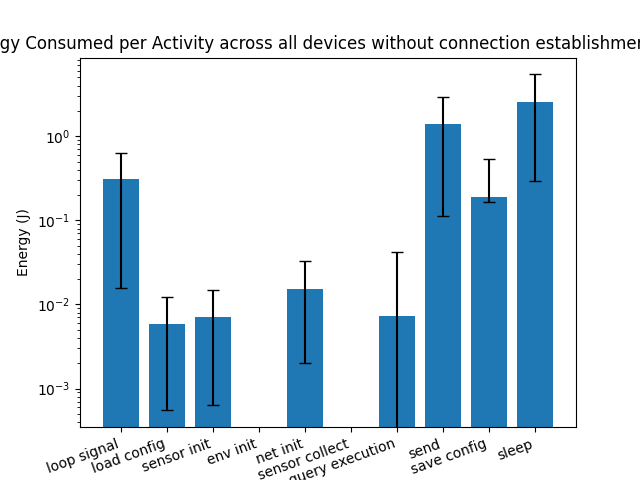

In [48]:
to_plot = without_0th_loop_summary[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
errors = errors_with_0th_loop[["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
#energy_consumed_without_0th_loop
plt.figure()
plt.bar(to_plot.columns, to_plot.loc["mean"], yerr=errors, capsize=4, log=True)
plt.xticks(rotation=20, ha="right")

plt.xlabel("Activity")
plt.ylabel("Energy (J)")
plt.title("Energy Consumed per Activity across all devices without connection establishment loop")
plt.show()

In [49]:
without_0th_loop.groupby("node_id").describe()

loop_num                                                  \
                    count  mean        std  min    25%   50%    75%   max   
node_id                                                                     
70B3D57ED005EA59     52.0  26.5  15.154757  1.0  13.75  26.5  39.25  52.0   
70B3D57ED005EA60     29.0  15.0   8.514693  1.0   8.00  15.0  22.00  29.0   
70B3D57ED005EA61     63.0  32.0  18.330303  1.0  16.50  32.0  47.50  63.0   
70B3D57ED005EA62     36.0  18.5  10.535654  1.0   9.75  18.5  27.25  36.0   
70B3D57ED005EA63      4.0   2.5   1.290994  1.0   1.75   2.5   3.25   4.0   
70B3D57ED005EA65     38.0  19.5  11.113055  1.0  10.25  19.5  28.75  38.0   
70B3D57ED005EA66     28.0  14.5   8.225975  1.0   7.75  14.5  21.25  28.0   
70B3D57ED005EA67     46.0  23.5  13.422618  1.0  12.25  23.5  34.75  46.0   
70B3D57ED005EA69     21.0  11.0   6.204837  1.0   6.00  11.0  16.00  21.0   
70B3D57ED005EA70     63.0  32.0  18.330303  1.0  16.50  32.0  47.50  63.0   
70B3D57ED005EA71     63.0  32.0  18.330303  1.0  16.50  32.0  47.50  63.0   
70B3D57ED005EA73     46.0  23.5  13.422618  1.0  12.25  23.5  34.75  46.0   
70B3D57ED005EA75     55.0  28.0  16.020820  1.0  14.50  28.0  41.50  55.0   
70B3D57ED005EA76      4.0   2.5   1.290994  1.0   1.75   2.5   3.25   4.0   
70B3D57ED005EA77     29.0  15.0   8.514693  1.0   8.00  15.0  22.00  29.0   

                 total            ... save config           sleep            \
                 count      mean  ...         75%       max count      mean   
node_id                           ...                                         
70B3D57ED005EA59  52.0  4.810640  ...    0.362056  0.365911  52.0  2.608150   
70B3D57ED005EA60  29.0  4.552143  ...    0.149842  0.151206  29.0  2.651929   
70B3D57ED005EA61  63.0  4.482846  ...    0.145829  0.146760  63.0  2.601321   
70B3D57ED005EA62  36.0  4.782587  ...    0.353990  0.356740  36.0  2.585574   
70B3D57ED005EA63   4.0  4.518566  ...    0.148015  0.148122   4.0  2.626542   
70B3D57ED005EA65  38.0  4.309132  ...    0.141199  0.142397  38.0  2.500491   
70B3D57ED005EA66  28.0  4.793375  ...    0.354100  0.355767  28.0  2.593620   
70B3D57ED005EA67  46.0  4.578817  ...    0.151828  0.152918  46.0  2.668516   
70B3D57ED005EA69  21.0  4.461715  ...    0.145619  0.145780  21.0  2.587686   
70B3D57ED005EA70  63.0  4.447525  ...    0.146194  0.147234  63.0  2.594017   
70B3D57ED005EA71  63.0  4.461091  ...    0.146888  0.147619  63.0  2.588828   
70B3D57ED005EA73  46.0  4.513323  ...    0.149087  0.150261  46.0  2.626960   
70B3D57ED005EA75  55.0  4.024551  ...    0.132196  0.133085  55.0  2.308411   
70B3D57ED005EA76   4.0  4.767363  ...    0.353334  0.353408   4.0  2.567725   
70B3D57ED005EA77  29.0  4.442061  ...    0.145005  0.145384  29.0  2.582821   

                                                                              
                       std       min       25%       50%       75%       max  
node_id                                                                       
70B3D57ED005EA59  0.093778  2.372297  2.634388  2.643855  2.652263  2.668830  
70B3D57ED005EA60  0.015693  2.624226  2.640703  2.649251  2.664266  2.679599  
70B3D57ED005EA61  0.009693  2.585237  2.594309  2.600177  2.606926  2.618507  
70B3D57ED005EA62  0.307739  0.792957  2.620322  2.633597  2.649129  2.662918  
70B3D57ED005EA63  0.015127  2.612290  2.614058  2.627056  2.639540  2.639766  
70B3D57ED005EA65  0.011524  2.481423  2.491180  2.500515  2.509112  2.520366  
70B3D57ED005EA66  0.303477  1.046544  2.637536  2.650449  2.662940  2.674738  
70B3D57ED005EA67  0.008831  2.655154  2.661607  2.668746  2.675191  2.681896  
70B3D57ED005EA69  0.001405  2.585774  2.586681  2.587337  2.588324  2.591643  
70B3D57ED005EA70  0.006869  2.582231  2.589246  2.593154  2.600441  2.607241  
70B3D57ED005EA71  0.006129  2.579429  2.584057  2.586980  2.594163  2.601117  
70B3D57ED005EA73  0.016426  2.599943  2.612761  2.626977  2.636962  2.653922  
70B3D57ED005EA75  0.16

In [50]:
## plot per node
grouped = without_0th_loop[["node_id","loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] \
    .groupby("node_id")
grouped_agg = grouped.agg(["mean", "std"])
def hej(row: pd.Series):
    outermost_column = list(set(k[0] for k in row.keys()))
    idx = pd.MultiIndex.from_product([outermost_column, ["low","high"]])
    res = pd.Series(index=idx)
    for col in outermost_column:
        res[col] = calc_confidence_interval(row[col])
    return res
ci = grouped_agg.apply(hej, axis=1)
ci

query execution            net init           loop signal  \
                             low      high       low      high         low   
node_id                                                                      
70B3D57ED005EA59        0.034424  0.035378  0.016286  0.016635    0.306182   
70B3D57ED005EA60        0.000000  0.000000  0.016153  0.016875    0.313409   
70B3D57ED005EA61        0.000000  0.000000  0.015853  0.016371    0.308885   
70B3D57ED005EA62        0.033954  0.035156  0.015737  0.016204    0.305528   
70B3D57ED005EA63        0.000000  0.000000  0.015987  0.016560    0.307969   
70B3D57ED005EA65        0.000000  0.000000  0.015008  0.015368    0.296680   
70B3D57ED005EA66        0.034060  0.035177  0.016136  0.016625    0.310276   
70B3D57ED005EA67        0.000000  0.000000  0.015793  0.016542    0.311363   
70B3D57ED005EA69        0.000000  0.000000  0.015777  0.016412    0.309987   
70B3D57ED005EA70        0.000000  0.000000  0.015879  0.016147    0.304090   
70B3D57ED005EA71        0.000000  0.000000  0.014157  0.014471    0.306695   
70B3D57ED005EA73        0.000000  0.000000  0.014367  0.014771    0.309133   
70B3D57ED005EA75        0.000000  0.000000  0.012987  0.013635    0.283612   
70B3D57ED005EA76        0.034518  0.035396  0.014434  0.014549    0.308780   
70B3D57ED005EA77        0.000000  0.000000  0.014293  0.014448    0.308816   

                               sleep           save config            \
                      high       low      high         low      high   
node_id                                                                
70B3D57ED005EA59  0.311039  2.424348  2.791951    0.345271  0.368465   
70B3D57ED005EA60  0.320676  2.621171  2.682686    0.146821  0.151305   
70B3D57ED005EA61  0.312937  2.582324  2.620318    0.143858  0.146749   
70B3D57ED005EA62  0.311724  1.982417  3.188731    0.346769  0.356881   
70B3D57ED005EA63  0.313894  2.596893  2.656190    0.145422  0.149070   
70B3D57ED005EA65  0.302055  2.477903  2.523079    0.138687  0.142508   
70B3D57ED005EA66  0.316319  1.998816  3.188423    0.348721  0.356203   
70B3D57ED005EA67  0.315902  2.651209  2.685824    0.149668  0.152926   
70B3D57ED005EA69  0.311113  2.584932  2.590440    0.145025  0.145807   
70B3D57ED005EA70  0.307901  2.580554  2.607480    0.144462  0.147060   
70B3D57ED005EA71  0.310614  2.576815  2.600842    0.145486  0.147665   
70B3D57ED005EA73  0.315505  2.594766  2.659154    0.146102  0.150311   
70B3D57ED005EA75  0.288764  1.985946  2.630877    0.130176  0.132916   
70B3D57ED005EA76  0.311522  2.330730  2.804721    0.352042  0.354087   
70B3D57ED005EA77  0.312239  2.574447  2.591195    0.144241  0.145449   

                 sensor collect      env init      load config            \
                            low high      low high         low      high   
node_id                                                                    
70B3D57ED005EA59            0.0  0.0      0.0  0.0    0.006086  0.006220   
70B3D57ED005EA60            0.0  0.0      0.0  0.0    0.005881  0.006531   
70B3D57ED005EA61            0.0  0.0      0.0  0.0    0.005716  0.005939   
70B3D57ED005EA62            0.0  0.0      0.0  0.0    0.005829  0.006157   
70B3D57ED005EA63            0.0  0.0      0.0  0.0    0.005553  0.006169   
70B3D57ED005EA65            0.0  0.0      0.0  0.0    0.005308  0.005425   
70B3D57ED005EA66            0.0  0.0      0.0  0.0    0.005957  0.006100   
70B3D57ED005EA67            0.0  0.0      0.0  0.0    0.005482  0.005943   
70B3D57ED005EA69            0.0  0.0      0.0  0.0    0.005854  0.006364   
70B3D57ED005EA70            0.0  0.0      0.0  0.0    0.005362  0.005922   
70B3D57ED005EA71            0.0  0.0      0.0  0.0    0.005489  0.005578   
70B3D57ED005EA73            0.0  0.0      0.0  0.0    0.006038  0.006299   
70B3D57ED005EA75            0.0  0.0      0.0  0.0    0.005503  0.005620   
70B3D57ED005EA76            0.0  0.0      0.0  0.0    0.006271  0.006306   
70B3D57ED005EA77       

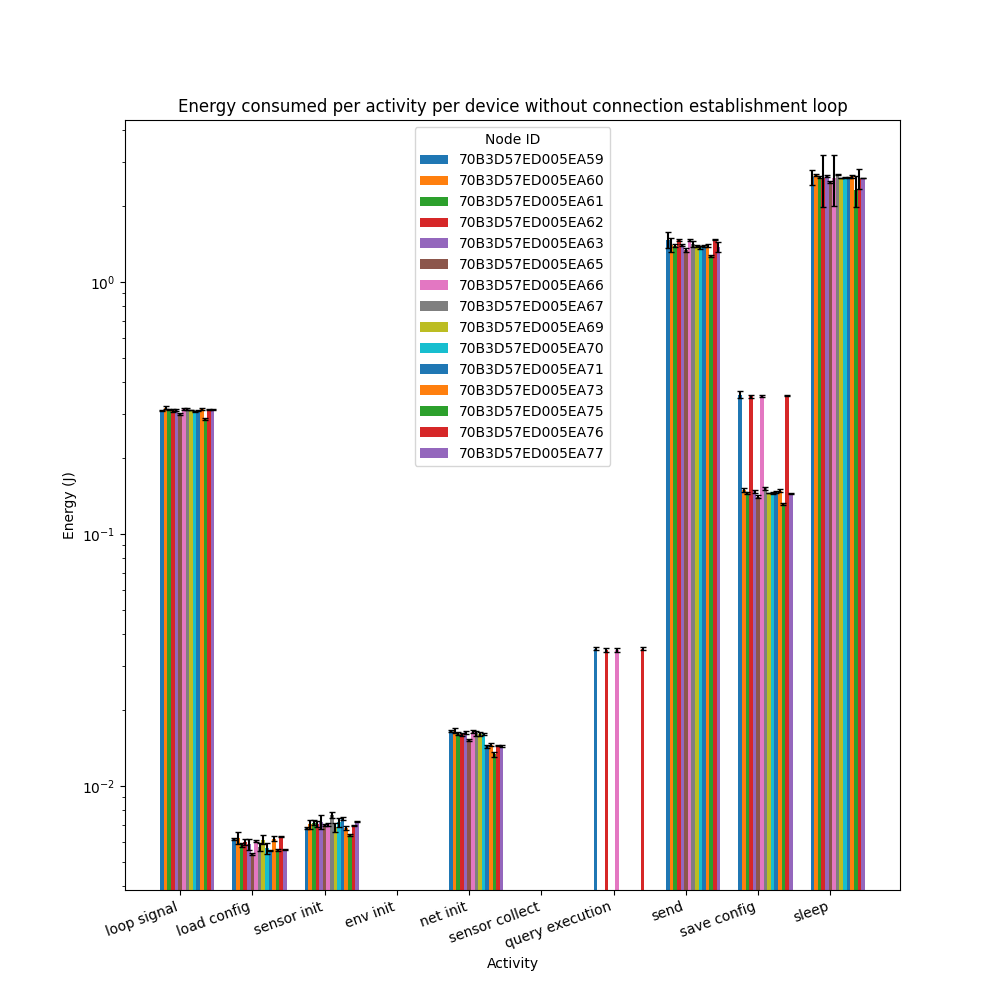

ValueError: 4 is not a valid MouseButton

In [51]:
outer_columns = list(grouped_agg.columns.get_level_values(0).unique())
locations = np.arange(len(outer_columns))
width = 0.05
multiplier = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for node_id, row in grouped_agg.groupby(level=0):
    values = row.loc[node_id,(slice(None),"mean")][["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]].values
    errors_low = values - ci.loc[node_id,(slice(None),"low")][["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]]
    errors_high = ci.loc[node_id,(slice(None),"high")][["loop signal", "load config", "sensor init", "env init", "net init", "sensor collect", "query execution", "send", "save config", "sleep"]] - values
    # for node_id, mean in row.loc[activity,"mean"].items():
    offset = width * multiplier

    rects = ax.bar(locations + offset, values, width, capsize=2, yerr=[errors_low, errors_high], label=node_id, log=True)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.legend(title="Node ID")
ax.set_title("Energy consumed per activity per device without connection establishment loop")
ax.set_ylabel("Energy (J)")
ax.set_xlabel("Activity")
ax.set_xticks(locations + 0.25, outer_columns, rotation=20, ha="right")
plt.show()

In [52]:
import gc
gc.collect()

1424

In [53]:

#TODO: vis distribution over query execution means
# IFT: 2 modaliteter: selectivity på filtre. lav exp med forskl. selectivity og regression til cost model
# størrelse af query: save cost afhænger af query størrelse

# TODO: from Viktor
# before doing the above try to from the data you have derive a power consumption per time period and estimate the powerconsumption linearly based on the time the activity takes
# regarding outliars in the total plot. Remove them. 
